# Johns Hopkins COVID Data Analysis 

https://opendatascience.com/johns-hopkins-covid-data-using-julia-for-management-analysis/

In [1]:
using DataFrames
using PyCall
using RCall
using RDatasets
using CSV
using DataFramesMeta
using Base
using Dates
using Feather
using Gadfly
using DataTables
using RollingFunctions
using Printf
using Query

# Utilities

In [2]:
macro timend()
    stop = time()
    elapsed = stop-start
    println(elapsed)
end

function pr(howmany)
    for i = 1:howmany
        println()
    end
end

function showln(obj)
    show(obj)
    pr(2)
end

function metaj(df;data=false)
    println(DataFrames.typeof(df))
    println(DataFrames.size(df))
    println(hcat(names(df),eltypes(df)))
    if data
        print(DataFrames.first(df,6))
        pr(1)
        print(DataFrames.last(df,6))
    end
    pr(2)
end

function frequencies(df,vars)
    freqs = combine(DataFrames.groupby(df, vars), nrow)
    freqs = DataFrames.rename(freqs, :nrow => :count);
    freqs[!,:percent] = 100*freqs.count/sum(freqs.count);
    sort!(freqs, [DataFrames.order(:count, rev = true)]);
    return(freqs)
end

function sumna(vec) return(sum(skipmissing(vec))) end

function mknames(df)
    from = names(df);
    to = [Symbol(replace(lowercase(string(f))," " => "")) for f in from];
    to = [Symbol(replace(lowercase(string(t)),"_" => "")) for t in to];
    return(to)
end

mknames (generic function with 1 method)

In [3]:
set_default_plot_size(12cm, 12cm);
Gadfly.push_theme(:default);

## Cases

In [4]:
start = time()
burl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/";
fname = "csse_covid_19_time_series/time_series_covid19_confirmed_US.csv";
mkpath("csse_covid_19_time_series");
mv(download(string(burl,fname)), fname, force=true);
@timend
print(fname)

1.1005439758300781
csse_covid_19_time_series/time_series_covid19_confirmed_US.csv

In [5]:
covidcases = CSV.read(fname, DataFrame);

In [6]:
describe(covidcases);

In [7]:
print(last(covidcases[:,[1,5,9,10,11,200]],15));

15×6 DataFrame
│ Row │ UID      │ FIPS     │ Lat     │ Long_    │ Combined_Key            │ 7/28/20 │
│     │ Int64    │ Float64? │ Float64 │ Float64  │ String                  │ Int64   │
├─────┼──────────┼──────────┼─────────┼──────────┼─────────────────────────┼─────────┤
│ 1   │ 84056021 │ 56021.0  │ 41.307  │ -104.689 │ Laramie, Wyoming, US    │ 432     │
│ 2   │ 84056023 │ 56023.0  │ 42.2638 │ -110.656 │ Lincoln, Wyoming, US    │ 88      │
│ 3   │ 84056025 │ 56025.0  │ 42.9618 │ -106.798 │ Natrona, Wyoming, US    │ 209     │
│ 4   │ 84056027 │ 56027.0  │ 43.0561 │ -104.476 │ Niobrara, Wyoming, US   │ 2       │
│ 5   │ 84080056 │ 80056.0  │ 0.0     │ 0.0      │ Out of WY, Wyoming, US  │ 0       │
│ 6   │ 84056029 │ 56029.0  │ 44.5216 │ -109.585 │ Park, Wyoming, US       │ 107     │
│ 7   │ 84056031 │ 56031.0  │ 42.133  │ -104.966 │ Platte, Wyoming, US     │ 5       │
│ 8   │ 84056033 │ 56033.0  │ 44.7905 │ -106.886 │ Sheridan, Wyoming, US   │ 44      │
│ 9   │ 84056035 │ 56035.0  

In [8]:
start = time()

nc = ncol(covidcases);
covidcasesm = DataFrames.stack(covidcases,12:nc);
covidcasesm = DataFrames.rename(covidcasesm, :variable => :date);
covidcasesm = DataFrames.rename(covidcasesm, :value => :cumcases);

rename!(covidcasesm, mknames(covidcasesm)) 

df = DateFormat("mm/dd/yy");
covidcasesm[:date] = [Date(string(d),df) for d in covidcasesm[:date]]

sort!(covidcasesm, [:uid, :date]);

metaj(covidcasesm);

@timend

DataFrame
(995320, 13)
Any["uid" Int64; "iso2" String; "iso3" String; "code3" Int64; "fips" Union{Missing, Float64}; "admin2" Union{Missing, String}; "provincestate" String; "countryregion" String; "lat" Float64; "long" Float64; "combinedkey" String; "date" Date; "cumcases" Int64]


8.120044946670532


In [9]:
# TODO: validate dailycases < 0
describe(covidcasesm)

,variable,mean,min,median,max
,Symbol,Union…,Any,Union…,Any
1,uid,8.34296e7,16,8.40292e7,84099999
2,iso2,,AS,,VI
3,iso3,,ASM,,VIR
4,code3,834.492,16,840.0,850
5,fips,33061.7,60.0,31014.0,99999.0
6,admin2,,Abbeville,,Ziebach
7,provincestate,,Alabama,,Wyoming
8,countryregion,,US,,US
9,lat,36.7072,-14.271,38.0023,69.3148


In [38]:
using StatsPlots
using Distributions
histogram(covidcasesm[:cumcases])

In [11]:
start = time()

grpvars = [:uid]

gdf = DataFrames.groupby(covidcasesm,grpvars);

@timend

0.808668851852417


In [12]:
summary(gdf)

"GroupedDataFrame with 3340 groups based on key: uid"

In [13]:
function diffsm(a)
   return cat([missing],diff(a),dims=1)
end

start = time()

slug = combine(gdf,:cumcases => diffsm => :dailycases)
metaj(slug)

@timend

DataFrame
(995320, 2)
Any["uid" Int64; "dailycases" Union{Missing, Int64}]


3.971419095993042


In [14]:
start = time()

covidcasesm = hcat(covidcasesm[:,1:13],slug[[:dailycases]]);
metaj(covidcasesm)

@timend

DataFrame
(995320, 14)
Any["uid" Int64; "iso2" String; "iso3" String; "code3" Int64; "fips" Union{Missing, Float64}; "admin2" Union{Missing, String}; "provincestate" String; "countryregion" String; "lat" Float64; "long" Float64; "combinedkey" String; "date" Date; "cumcases" Int64; "dailycases" Union{Missing, Int64}]


0.27637410163879395


In [15]:
print(sumna(covidcasesm[:dailycases]))

10903889

### Boston

In [16]:
covidcases |> @filter(_.Province_State ∈ ["Massachusetts"]) |> @filter(_.Admin2 ∈ ["Middlesex", "Suffolk"]) |> DataFrame

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region
,Int64,String,String,Int64,Float64?,String?,String,String
1,84025017,US,USA,840,25017.0,Middlesex,Massachusetts,US
2,84025025,US,USA,840,25025.0,Suffolk,Massachusetts,US


In [17]:
# alternative to df[df[:admin2].="Middlesex"]
df_boston = covidcasesm |> @filter(_.provincestate ∈ ["Massachusetts"]) |> @filter(_.admin2 ∈ ["Middlesex", "Suffolk"]) |> DataFrame
df_boston_cases = df_boston[[:date, :cumcases, :dailycases]]
sort!(df_boston_cases, [:date], rev=true)

,date,cumcases,dailycases
,Date,Int64,Int64?
1,0020-11-14,37652,539
2,0020-11-14,32561,373
3,0020-11-13,37113,562
4,0020-11-13,32188,397
5,0020-11-12,36551,528
6,0020-11-12,31791,337
7,0020-11-11,36023,507
8,0020-11-11,31454,296
9,0020-11-10,35516,339


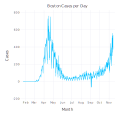

In [18]:
title = @sprintf "Boston Cases per Day"

g = Gadfly.plot(df_boston_cases, x=:date, y=:dailycases,  
Gadfly.Geom.line,
    Gadfly.Scale.y_continuous(minvalue=0,format=:plain),
    Guide.XLabel("Month"),
    Guide.YLabel("Cases"),
    Guide.Title(title))

## Deaths

In [19]:
start = time()

burl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/";
fname = "csse_covid_19_time_series/time_series_covid19_deaths_US.csv";

mv(download(string(burl,fname)), fname, force=true)

@timend

0.5381019115447998


In [20]:
coviddeaths = CSV.read(fname, DataFrame)
metaj(coviddeaths)

DataFrame
(3340, 310)
Any["UID" Int64; "iso2" String; "iso3" String; "code3" Int64; "FIPS" Union{Missing, Float64}; "Admin2" Union{Missing, String}; "Province_State" String; "Country_Region" String; "Lat" Float64; "Long_" Float64; "Combined_Key" String; "Population" Int64; "1/22/20" Int64; "1/23/20" Int64; "1/24/20" Int64; "1/25/20" Int64; "1/26/20" Int64; "1/27/20" Int64; "1/28/20" Int64; "1/29/20" Int64; "1/30/20" Int64; "1/31/20" Int64; "2/1/20" Int64; "2/2/20" Int64; "2/3/20" Int64; "2/4/20" Int64; "2/5/20" Int64; "2/6/20" Int64; "2/7/20" Int64; "2/8/20" Int64; "2/9/20" Int64; "2/10/20" Int64; "2/11/20" Int64; "2/12/20" Int64; "2/13/20" Int64; "2/14/20" Int64; "2/15/20" Int64; "2/16/20" Int64; "2/17/20" Int64; "2/18/20" Int64; "2/19/20" Int64; "2/20/20" Int64; "2/21/20" Int64; "2/22/20" Int64; "2/23/20" Int64; "2/24/20" Int64; "2/25/20" Int64; "2/26/20" Int64; "2/27/20" Int64; "2/28/20" Int64; "2/29/20" Int64; "3/1/20" Int64; "3/2/20" Int64; "3/3/20" Int64; "3/4/20" Int64; "3/5/20"

In [21]:
nc = ncol(coviddeaths);
coviddeathsm = DataFrames.stack(coviddeaths,13:nc);
coviddeathsm = DataFrames.rename(coviddeathsm, :variable => :date);
coviddeathsm = DataFrames.rename(coviddeathsm, :value => :cumdeaths);

rename!(coviddeathsm, mknames(coviddeathsm)) 

df = DateFormat("mm/dd/yy");
coviddeathsm[:date] = [Date(string(d),df) for d in coviddeathsm[:date]]

sort!(coviddeathsm, [:uid, :date]);
metaj(coviddeathsm)

DataFrame
(995320, 14)
Any["uid" Int64; "iso2" String; "iso3" String; "code3" Int64; "fips" Union{Missing, Float64}; "admin2" Union{Missing, String}; "provincestate" String; "countryregion" String; "lat" Float64; "long" Float64; "combinedkey" String; "population" Int64; "date" Date; "cumdeaths" Int64]




In [22]:
grpvars = [:uid]

gdf = DataFrames.groupby(coviddeathsm,grpvars);

In [23]:
slug = combine(gdf,:cumdeaths => diffsm => :dailydeaths)
metaj(slug)

DataFrame
(995320, 2)
Any["uid" Int64; "dailydeaths" Union{Missing, Int64}]




In [24]:
coviddeathsm = hcat(coviddeathsm[:,1:14],slug[[:dailydeaths]]);

In [25]:
describe(coviddeathsm)

,variable,mean,min,median,max
,Symbol,Union…,Any,Union…,Any
1,uid,8.34296e7,16,8.40292e7,84099999
2,iso2,,AS,,VI
3,iso3,,ASM,,VIR
4,code3,834.492,16,840.0,850
5,fips,33061.7,60.0,31014.0,99999.0
6,admin2,,Abbeville,,Ziebach
7,provincestate,,Alabama,,Wyoming
8,countryregion,,US,,US
9,lat,36.7072,-14.271,38.0023,69.3148


In [26]:
print(sumna(coviddeathsm.dailydeaths))

245598

## Cases and Deaths

In [27]:
start = time()

covidfinal = innerjoin(covidcasesm,coviddeathsm[[:uid,:date,:cumdeaths,:dailydeaths]], on = [:uid => :uid, :date => :date]);
metaj(covidfinal)

@timend

DataFrame
(995320, 16)
Any["uid" Int64; "iso2" String; "iso3" String; "code3" Int64; "fips" Union{Missing, Float64}; "admin2" Union{Missing, String}; "provincestate" String; "countryregion" String; "lat" Float64; "long" Float64; "combinedkey" String; "date" Date; "cumcases" Int64; "dailycases" Union{Missing, Int64}; "cumdeaths" Int64; "dailydeaths" Union{Missing, Int64}]


3.116037130355835


In [28]:
dailycases = dropmissing(covidfinal, :dailycases)
sort!(dailycases[:,[:combinedkey,:date,:cumcases,:dailycases,:cumdeaths,:dailydeaths]], [:dailycases, :date], rev=true)

,combinedkey,date,cumcases,dailycases,cumdeaths,dailydeaths
,String,Date,Int64,Int64,Int64,Int64?
1,"Harris, Texas, US",0020-09-21,137946,14129,2505,1
2,"Los Angeles, California, US",0020-07-05,115024,7198,3487,30
3,"Bexar, Texas, US",0020-07-16,27047,5980,229,28
4,"Cook, Illinois, US",0020-11-13,242662,5945,5895,6
5,"Dallas, Texas, US",0020-08-16,63428,5361,825,1
6,"Cook, Illinois, US",0020-11-06,210266,5289,5742,168
7,"Cook, Illinois, US",0020-11-12,236717,5255,5889,8
8,"Los Angeles, California, US",0020-07-29,183456,4814,4518,92
9,"Cook, Illinois, US",0020-11-07,214924,4658,5770,28


In [29]:
println("Total cases: ", sumna(covidfinal.dailycases))
print("Total deaths: ", sumna(covidfinal[:dailydeaths]))

Total cases: 10903889
Total deaths: 245598

In [30]:
function masm_1(a;window=14)
    a = convert(Array{Float64,1}, a)
    lena = length(a);
    b = similar(a)
    for j in lena:-1:window
        summ = 0
        for jj in j:-1:(j-window+1)
            summ += a[jj]
        end
        b[j] = round(summ/window)
    end
    return(cat(fill(missing,window-1),b[window:lena],dims=1))
end

ustotal = by(covidfinal, [:date], :dailycases => sumna => :dailycases, :dailydeaths => sumna => :dailydeaths);

ustotal["dayofweek"] = Dates.format.(ustotal.date,"e")
ustotal[:cumcases] = cumsum(ustotal.dailycases)
ustotal[:cumdeaths] = cumsum(ustotal.dailydeaths)

ustotal[:macases7] = masm_1(ustotal[:dailycases],window=7);
ustotal[:madeaths7] = masm_1(ustotal[:dailydeaths],window=7);
ustotal[:macases14] = masm_1(ustotal[:dailycases],window=14);
ustotal[:madeaths14] = masm_1(ustotal[:dailydeaths],window=14);

metaj(ustotal)

print(last(ustotal,14))

DataFrame
(298, 10)
Any["date" Date; "dailycases" Int64; "dailydeaths" Int64; "dayofweek" String; "cumcases" Int64; "cumdeaths" Int64; "macases7" Union{Missing, Float64}; "madeaths7" Union{Missing, Float64}; "macases14" Union{Missing, Float64}; "madeaths14" Union{Missing, Float64}]


14×10 DataFrame
│ Row │ date       │ dailycases │ dailydeaths │ dayofweek │ cumcases │ cumdeaths │ macases7 │ madeaths7 │ macases14 │ madeaths14 │
│     │ Date       │ Int64      │ Int64       │ String    │ Int64    │ Int64     │ Float64? │ Float64?  │ Float64?  │ Float64?   │
├─────┼────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┼──────────┼───────────┼───────────┼────────────┤
│ 1   │ 0020-11-01 │ 76456      │ 407         │ Sun       │ 9199121  │ 231532    │ 81877.0  │ 825.0     │ 76023.0   │ 816.0      │
│ 2   │ 0020-11-02 │ 81880      │ 536         │ Mon       │ 9281001  │ 232068    │ 84146.0  │ 829.0     │ 77115.0   │ 821.0      │
│ 3   │ 0020-11-03 │ 123056     │ 1571      

In [31]:
usdayofweek = by(ustotal, [:dayofweek], :dailycases => sumna => :dailycases, :dailydeaths => sumna => :dailydeaths);
usdayofweek["pctcases"] = round.(100*usdayofweek.dailycases/sumna(usdayofweek.dailycases);digits=2);
usdayofweek["pctdeaths"] = round.(100*usdayofweek.dailydeaths/sumna(usdayofweek.dailydeaths);digits=2);

print(hcat(frequencies(ustotal,["dayofweek"])[1:2],usdayofweek[[2,4,3,5]]))

7×6 DataFrame
│ Row │ dayofweek │ count │ dailycases │ pctcases │ dailydeaths │ pctdeaths │
│     │ String    │ Int64 │ Int64      │ Float64  │ Int64       │ Float64   │
├─────┼───────────┼───────┼────────────┼──────────┼─────────────┼───────────┤
│ 1   │ Wed       │ 43    │ 1561721    │ 14.32    │ 44163       │ 17.98     │
│ 2   │ Thu       │ 43    │ 1716515    │ 15.74    │ 40614       │ 16.54     │
│ 3   │ Fri       │ 43    │ 1821493    │ 16.7     │ 39720       │ 16.17     │
│ 4   │ Sat       │ 43    │ 1675917    │ 15.37    │ 34234       │ 13.94     │
│ 5   │ Sun       │ 42    │ 1287311    │ 11.81    │ 20458       │ 8.33      │
│ 6   │ Mon       │ 42    │ 1329434    │ 12.19    │ 24138       │ 9.83      │
│ 7   │ Tue       │ 42    │ 1511498    │ 13.86    │ 42271       │ 17.21     │

In [32]:
mkpath("data/covid19");
fname = "data/covid19/covidfinal.feather"
Feather.write(fname,covidfinal)

"data/covid19/covidfinal.feather"

In [33]:
title = @sprintf "%s%s to %s\nCases: %s; Deaths: %s\n" "Covid 19 in the U.S.\n" first(ustotal).date last(ustotal).date sumna(ustotal.dailycases) sumna(ustotal.dailydeaths)
annodate = last(ustotal).date + Dates.Day(15)
annodatestr = string(last(ustotal).date)
annocases = last(ustotal).macases7
annocasesstr = last(ustotal).macases7
annodeaths = last(ustotal).madeaths14
annodeathsstr = last(ustotal).madeaths14

1034.0

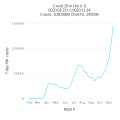

In [34]:
g = Gadfly.plot(ustotal, x=:date, y=:macases7,  
Gadfly.Geom.line,
    Gadfly.Scale.y_continuous(minvalue=0,format=:plain),
    Guide.XLabel("Month"),
    Guide.YLabel("7 day MA cases"),
    Guide.Title(title))

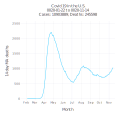

In [35]:
g = Gadfly.plot(ustotal, x=:date, y=:madeaths14, 
    Gadfly.Geom.line,
    Gadfly.Scale.y_continuous(minvalue=0,format=:plain),
    Guide.XLabel("Month"),
    Guide.YLabel("14 day MA deaths"),
    Guide.Title(title))

In [36]:
function masm_2(vec,win)
    return(cat(fill(missing,win-1),RollingFunctions.rollmean(vec,win),dims=1))
end

print(last(DataFrame(macases14_1=round.(masm_2(ustotal.dailycases,14);digits=0),macases14_2=ustotal.macases14),14))

14×2 DataFrame
│ Row │ macases14_1 │ macases14_2 │
│     │ Float64?    │ Float64?    │
├─────┼─────────────┼─────────────┤
│ 1   │ 76023.0     │ 76023.0     │
│ 2   │ 77115.0     │ 77115.0     │
│ 3   │ 81552.0     │ 81552.0     │
│ 4   │ 84432.0     │ 84432.0     │
│ 5   │ 88220.0     │ 88220.0     │
│ 6   │ 91246.0     │ 91246.0     │
│ 7   │ 94432.0     │ 94432.0     │
│ 8   │ 97848.0     │ 97848.0     │
│ 9   │ 101702.0    │ 101702.0    │
│ 10  │ 106323.0    │ 106323.0    │
│ 11  │ 110964.0    │ 110964.0    │
│ 12  │ 116006.0    │ 116006.0    │
│ 13  │ 121679.0    │ 121679.0    │
│ 14  │ 127230.0    │ 127230.0    │